In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm,t 
import matplotlib.pyplot as plt

# Local Import
from utility import load_data

In [3]:
# Load Data
df = load_data('DASH_merged.txt')
df.head()

,positive_score_en,negative_score_en,score_en,positive_volume_en,negative_volume_en,volume_ratio_en,total_volume_en,total_volume_non_en,total_volume_global,close,high,low,open,volumefrom,volumeto,logclose,loghigh,loglow,logopen,fluctuation
time,,,,,,,,,,,,,,,,,,,,
2018-01-02 11:00:00,2.040000,1.339500,0.700500,3,1,3.0000,48,3,51,1092.99,1098.78,1089.73,1097.59,973.44,1063595.19,6.996672,7.001956,6.993685,7.000872,-0.004200
2018-01-02 12:00:00,1.750175,1.512967,0.237208,16,3,5.3333,212,30,242,1089.11,1099.60,1085.70,1092.99,465.27,509020.53,6.993116,7.002702,6.989980,6.996672,-0.003556
2018-01-02 13:00:00,1.901171,1.776850,0.124321,38,6,6.3333,226,33,259,1113.63,1115.54,1089.19,1089.28,1576.62,1740882.55,7.015380,7.017094,6.993190,6.993272,0.022108
2018-01-02 14:00:00,2.065209,1.442150,0.623059,32,4,8.0000,255,17,272,1104.40,1117.30,1102.59,1113.25,883.14,980074.94,7.007057,7.018670,7.005417,7.015039,-0.007981
2018-01-02 15:00:00,1.757532,1.685425,0.072107,34,4,8.5000,247,17,264,1100.28,1107.73,1090.27,1104.89,640.29,704188.97,7.003320,7.010068,6.994181,7.007501,-0.004181


In [26]:
# Log Returns
r = df['logclose'].pct_change().dropna()

# Aggregate log returns
# r = r.resample('D').sum()

# VaR Caclulation for increasing Time Window

In [6]:
# Define Inital Test Window Size and Confidence Level
tau = 20
alpha = 0.05

### Value at Risk - Non-Parametric

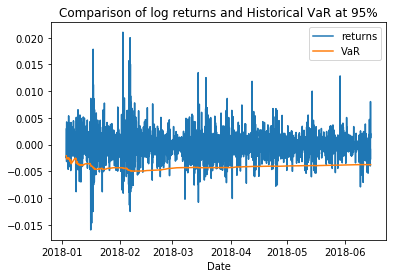

In [46]:
# Initialize list collect VaR
VaR_H = []

for i in range(len(r)-tau):
  #Parameters
  ts = r[:tau+i]

  #VaR
  VaR_H.append(ts.quantile(alpha)) 
  
  N = len(ts)
  ts_sorted = ts.sort_values()

# Plotting
fig,ax = plt.subplots()
ax.plot(r[tau:], label= 'returns')
ax.plot(r[tau:].index,VaR_H, label='VaR')
ax.set_xlabel('Date')
ax.set_title('Comparison of log returns and Historical VaR at 95%')
ax.legend()

### Value at Risk - Normal Distribution

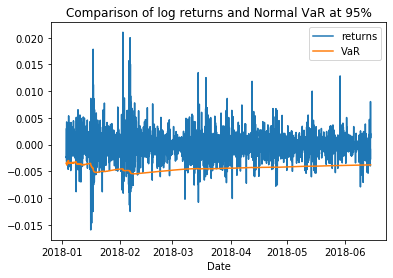

In [48]:
# Initialize list collect VaR
VaR_N = []

for i in range(0,len(r)-tau):
  #Parameters
  ts = r[0:tau+i]
  mu_norm, sig_norm = norm.fit(ts)

  #VaR
  VaR_N.append(mu_norm+sig_norm*norm.ppf(1-alpha)) 

# Plotting
fig, ax = plt.subplots()
ax.plot(r[tau:],label='returns')
ax.plot(r[tau:].index,-1*np.array(VaR_N), label='VaR')
ax.set_xlabel('Date')
ax.set_title('Comparison of log returns and Normal VaR at 95%')
ax.legend()

### Value at Risk - Student's t-Distribution

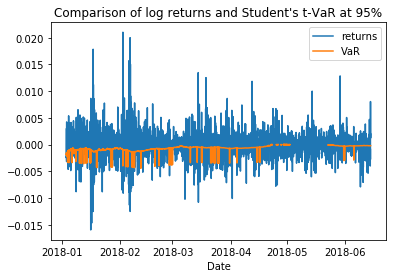

In [49]:
# Initialize list collect VaR
VaR_T = []
nu_list = []
for i in range(0,len(r)-tau):
  #Parameters
  ts = r[0:tau+i]
  mu = np.mean(ts)
  std = np.std(ts)

  nu, mu_t, sig_t = t.fit(ts)

  nu_list.append(nu)
  sig_t = ((nu-2)/nu)**0.5 * std

  #VaR
  VaR_T.append(mu + sig_t* t.ppf(1-0.05,nu))

# Plotting
fig, ax = plt.subplots()
ax.plot(r[tau:],label='returns')
ax.plot(r[tau:].index,-1*np.array(VaR_T), label='VaR')
ax.set_xlabel('Date')
ax.set_title("Comparison of log returns and Student's t-VaR at 95%")
ax.legend()

### VAR & ES  - Parametric (EWMA) 

In [27]:
# Initiate the EWMA using a warm-up phase to set up the standard deviation.
tau=20
Lambda = 0.94
Sigma2     = [r[0]**2]

for i in range(1,tau):
  Sigma2.append((1-Lambda) * r[i-1]**2 + Lambda * Sigma2[i-1])

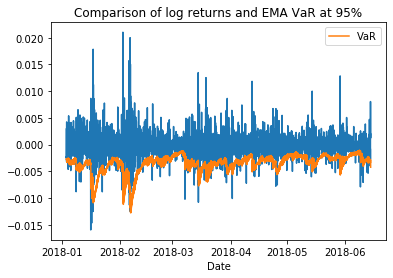

In [37]:
# Initialize list collect VaR
VaR_EWM = []

for i in range(tau,len(r)):    
    Sigma2.append(Lambda* Sigma2[i-1]+(1-Lambda)*r[i-1]**2)
    std = np.sqrt(Sigma2[i])

    #VaR 
    VaR_EWM.append(std*norm.ppf(1-alpha)) 

# Plotting
fig, ax = plt.subplots()
ax.plot(r[tau:],label='returns')
ax.plot(r[tau:].index,-1*np.array(VaR_EWM), label='VaR')
ax.set_xlabel('Date')
ax.set_title('Comparison of log returns and EMA VaR at 95%')
ax.legend()

In [ ]:
# Inspiration

# https://de.mathworks.com/help/risk/value-at-risk-estimation-and-backtesting-1.html
# https://uk.mathworks.com/help/risk/overview-of-var-backtesting.html
# https://mmquant.net/introduction-to-volatility-models-with-matlab-sma-ewma-cc-range-estimators/